# PART 3: MODEL CONSTRUCTION & EVALUATION

**Objective:** This notebook will construct an appropriate model and execute the technician-navigation application in order to study the potential benefits in productivity and operational costs.

---

In [1]:
# Data Management
import numpy as np
import pandas as pd
from prettytable import PrettyTable

# Modeling
import statsmodels as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, explained_variance_score 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from yellowbrick.model_selection import FeatureImportances, LearningCurve, ValidationCurve
from yellowbrick.regressor import PredictionError, ResidualsPlot

# Utils
import ast
import ipywidgets as widgets
import pprint
import random
import warnings
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
from ipywidgets import interact, interact_manual
from random import choice, choices, shuffle, randrange
from time import sleep
%matplotlib inline
sns.set_style('white')
sns.set_color_codes()
plt.style.use('default')
warnings.filterwarnings("ignore")
pp = pprint.PrettyPrinter(indent=0)

---
---

## 3A: Setup

**Objective**: Read in the clinic data & necessary patient records files.

---

In [2]:
past_patients_df = pd.read_csv('./uc_past_patients.csv', index_col='pt_id')
# past_patients_df = pd.read_csv('./fabricated_data/uc_past_patients.csv', index_col='pt_id')
past_patients_df.head()

,pt_name,pt_dob,pt_age,visit_location,visit_reason,visit_code,visit_date,visit_day,checkin_time,checkout_time,rolling_ct,rolling_code,assigned_num_techs,needed_num_techs
pt_id,,,,,,,,,,,,,,
1000002,Austin Pierce,1992-02-15,30,denver,injury/accident,5,2021-05-01,Saturday,08:31:53,09:46:53,1,0.0,4,1
1000006,Matthew Perez,2010-11-13,11,denver,vaccination,3,2021-05-01,Saturday,08:39:32,09:07:32,2,5.0,4,1
1000008,Sara Olson,1947-08-28,74,denver,cough,4,2021-05-01,Saturday,09:15:40,10:07:40,2,5.0,4,1
1000007,Kimberly Adams,1968-04-12,54,denver,cold/flu/fever,4,2021-05-01,Saturday,09:20:24,10:27:24,3,4.5,4,1
1000017,Adriana Johnston,1959-10-25,62,denver,weakness/dizziness,5,2021-05-01,Saturday,09:33:49,10:54:25,4,4.3,4,2


In [3]:
new_patients_df = pd.read_csv('./uc_new_patients.csv', index_col='pt_id')
# new_patients_df = pd.read_csv('./fabricated_data/uc_new_patients.csv', index_col='pt_id')
new_patients_df.head()

,pt_name,pt_dob,pt_age,visit_location,visit_reason,visit_code,visit_date,visit_day,checkin_time,checkout_time,rolling_ct,rolling_code,assigned_num_techs,needed_num_techs
pt_id,,,,,,,,,,,,,,
1026488,Robert Sanders,1962-04-28,60,denver,ear-pain,4,2022-05-01,Sunday,08:16:26,08:55:26,1,0.0,4,1
1026502,Robert Bridges,1987-08-01,34,denver,lab-work,3,2022-05-01,Sunday,08:50:22,09:38:22,2,4.0,4,1
1026483,Robert Green,2003-03-03,19,denver,stomach-pain,5,2022-05-01,Sunday,09:03:40,10:24:40,2,3.0,4,1
1026480,Destiny Burns,1986-06-21,35,denver,cold/flu/fever,4,2022-05-01,Sunday,09:14:23,10:25:23,3,4.0,4,1
1026490,Jimmy Hart,1956-07-10,65,denver,chest-pain,5,2022-05-01,Sunday,09:16:03,10:34:03,4,4.0,4,2


In [4]:
clinics_df = pd.read_csv('./uc_clinics.csv', index_col='branch_name')
# clinics_df

---
---

## 3B: Data Processing

**Objective**: Execute minor cleaning implementations due to lost data characteristics from CSV read-in.

---

#### Convert nearby_clinics info from str to original list format:

In [5]:
clinics_df['nearby_clinics'] = clinics_df.nearby_clinics.apply(lambda x: ast.literal_eval(x))  

In [6]:
clinics_df

,lat,lon,to_denver,to_edgewater,to_wheatridge,to_rino,to_lakewood,nearby_clinics
branch_name,,,,,,,,
denver,39.739064,-104.989697,0,12,14,7,14,"[(rino, 7.0), (edgewater, 12.0), (wheatridge, ..."
edgewater,39.753954,-105.067788,14,0,5,12,9,"[(wheatridge, 5.0), (lakewood, 9.0), (rino, 12..."
wheatridge,39.766857,-105.081983,14,5,0,10,9,"[(edgewater, 5.0), (lakewood, 9.0), (rino, 10...."
rino,39.767328,-104.981132,6,14,14,0,14,"[(denver, 6.0), (edgewater, 14.0), (wheatridge..."
lakewood,39.704552,-105.079883,12,8,8,12,0,"[(edgewater, 8.0), (wheatridge, 8.0), (denver,..."


#### Create appropriate datetime objects for visit date & check-in/out times:

In [7]:
def clean_pt_records(df):
    """Convers datetime info to appropriate formats from csv read-in data."""
    
    # Create unified date/time attribute for sorting purposes
    datetime_str = []
    for i in zip(df.visit_date, df.checkin_time):
        datetime_str.append(i[0] + ' ' + i[1])
    df['datetime'] = datetime_str

    # Sort based on datetime strings
    df = df.sort_values('datetime') #[50:200]

    # Rearrange column order
    df = df[['datetime'] + df.columns.tolist()[:-1]]
    
    # Convert visit date & check-in/out columns to datetime objects (csv converts them into strings)
    df['visit_date'] = df.visit_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d')).apply(lambda x: x.date())
    df['checkin_time'] = df.checkin_time.apply(lambda x: datetime.strptime(x, '%H:%M:%S')).apply(lambda x: x.time())
    df['checkout_time'] = df.checkout_time.apply(lambda x: datetime.strptime(x, '%H:%M:%S')).apply(lambda x: x.time())
    
    return df

In [8]:
past_patients_df = clean_pt_records(past_patients_df)
new_patients_df = clean_pt_records(new_patients_df)


#### Feature engineer new columns

In [9]:
# Weekend column - 1 for weekend, 0 for weekenday
def feature_engineer(df):
    df['weekend'] = df['visit_day'].copy().apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
    df['hour'] = df['checkin_time'].copy().apply(lambda x: x.hour)
    df = pd.concat([df, pd.get_dummies(df['visit_location'])], axis=1)
    df['hour'] = df.hour.astype('category')
    # print(df.dtypes)
    return df

In [10]:
new_patients_df = feature_engineer(new_patients_df)
past_patients_df = feature_engineer(past_patients_df)

In [11]:
past_patients_df

,datetime,pt_name,pt_dob,pt_age,visit_location,visit_reason,visit_code,visit_date,visit_day,checkin_time,...,rolling_code,assigned_num_techs,needed_num_techs,weekend,hour,denver,edgewater,lakewood,rino,wheatridge
pt_id,,,,,,,,,,,,,,,,,,,,,
2000016,2021-05-01 08:01:03,Timothy Wilson,1972-01-19,50,edgewater,ear-pain,4,2021-05-01,Saturday,08:01:03,...,0.0,3,1,1,8,0,1,0,0,0
3000003,2021-05-01 08:01:29,Jill Olson,1974-11-19,47,wheatridge,ache/pain,4,2021-05-01,Saturday,08:01:29,...,0.0,4,1,1,8,0,0,0,0,1
3000005,2021-05-01 08:04:56,Daniel Nixon,1972-12-07,49,wheatridge,rash/allergy,5,2021-05-01,Saturday,08:04:56,...,4.0,4,1,1,8,0,0,0,0,1
2000014,2021-05-01 08:05:31,Steven Cook,1976-10-07,45,edgewater,cold/flu/fever,4,2021-05-01,Saturday,08:05:31,...,4.0,3,1,1,8,0,1,0,0,0
3000009,2021-05-01 08:09:48,Brandon Smith,1976-03-30,46,wheatridge,chest-pain,5,2021-05-01,Saturday,08:09:48,...,4.5,4,1,1,8,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5023431,2022-04-30 19:41:55,Kathy Watson,1972-01-05,50,lakewood,covid-test,4,2022-04-30,Saturday,19:41:55,...,4.3,3,3,1,19,0,0,1,0,0
1026472,2022-04-30 19:44:04,Aimee Kelly,1969-12-06,52,denver,headache,5,2022-04-30,Saturday,19:44:04,...,4.5,4,1,1,19,1,0,0,0,0
5023450,2022-04-30 19:44:51,Amanda Harrison,1960-03-26,62,lakewood,vaccination,3,2022-04-30,Saturday,19:44:51,...,4.3,3,3,1,19,0,0,1,0,0


---
---

## 3C: Modeling Part I

**Objective**: Construct, validate, and evaluate traditional ML models to predict techs-needed at a particular time & location based on past patient records.

---

#### Data Partitioning:

In [20]:
X_train = past_patients_df[['denver', 'edgewater', 'wheatridge', 'rino', 'lakewood', 'weekend', 'hour']].copy()
y_train = past_patients_df['needed_num_techs'].copy()

X_test = new_patients_df[['denver', 'edgewater', 'wheatridge', 'rino', 'lakewood', 'weekend', 'hour']].copy()
y_test = new_patients_df['needed_num_techs'].copy()

The past patient records was used as the training set, while the "new" patient records will serve as the test set. 

#### Baseline Modeling:

In [21]:
def fit_model(model, X, y, table):
    """Constructs a given model based on input data and evaluates results among relevant metrics."""
    
    model = model.fit(X, y)
    pred = model.predict(X)
    r2 = round(r2_score(y, pred), 2)
    mae = round(mean_absolute_error(y, pred), 2)
    rmse = round(np.sqrt(mean_squared_error(y, pred)), 2)
    medae = round(median_absolute_error(y, pred), 2)  
    mape = round(mean_absolute_percentage_error(y, pred),2) 
    table.add_row([model, r2, mae, rmse, medae, mape])
    return table

def exec_regr(X, y, rs=42):
    """Executes streamlined-process using the input target variable."""
    
    # Define set of baseline models to iterate through
    models = [
        LinearRegression(),
        Lasso(random_state=rs),
        ElasticNet(random_state=rs),
        Ridge(random_state=rs),
        KNeighborsRegressor(),
        DecisionTreeRegressor(random_state=rs),
        RandomForestRegressor(random_state=rs),
    ]

    # Instantiate a tabular structure to store results from each model
    table = PrettyTable()
    table.field_names = ['Model', 'R2', 'MAE', 'RMSE', 'MedAE', 'MAPE']
    
    # Execute model
    for model in models:
        table = fit_model(model, X, y, table)

    return table

print(exec_regr(X_train, y_train))

+----------------------------------------+-------+------+------+-------+------+
|                 Model                  |   R2  | MAE  | RMSE | MedAE | MAPE |
+----------------------------------------+-------+------+------+-------+------+
|           LinearRegression()           |  0.1  | 0.64 | 0.81 |  0.58 | 0.4  |
|         Lasso(random_state=42)         |  0.0  | 0.6  | 0.85 |  0.98 | 0.39 |
|      ElasticNet(random_state=42)       |  0.0  | 0.6  | 0.85 |  0.98 | 0.39 |
|         Ridge(random_state=42)         |  0.1  | 0.64 | 0.81 |  0.57 | 0.4  |
|         KNeighborsRegressor()          | -0.02 | 0.67 | 0.86 |  0.6  | 0.37 |
| DecisionTreeRegressor(random_state=42) |  0.29 | 0.57 | 0.72 |  0.48 | 0.35 |
| RandomForestRegressor(random_state=42) |  0.29 | 0.57 | 0.72 |  0.48 | 0.35 |
+----------------------------------------+-------+------+------+-------+------+


A variety of regressor estimators were chosen to model the data, ranging from linear-regression based algorithms (including `Lasso`/`Ridge`/`ElasticNet`) to K-Nearest Neighbors to tree-based methods. 

The primary area where the linear-based regression techniques (standard `LinearRegression`, `Lasso`, `Ridge`, `ElasticNet`) differ is the penalization for weights assigned to the features. While the standard version has no penalities, Lasso aims to penalize based on sum of absolute values of weights and Ridge penalizes based on sum of squared weight values. 

On the other hand, tree-based regressors rely on a single tree (`DecisionTreeRegressor`) or an ensemble of trees (`RandomForestRegressor`) constructed from a set of binary splits of branches based on the satisfaction of attribute conditions that aim to reduce mean squared error with each split. A random forest algorithm aims that builds many random trees in parallel is especially known for its predictive capabilities but tree-based methods have a knack for overfitting data. 

Exploring these diverse methods, and assessing the models based on relevant metrics can help further narrow down the suitable method that best represents this dataset.

The releveant metrics chosen to evaluate the diverse set of regression models are: R^2, Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Median Absolute Error (MedAE), and Mean Absolute Percentage Error (MAPE). Outlined below is a high-level overview on how to interpret these metrics and the context in which they are used, followed by a discussion of the results above: 

`R^2`: Higher R^2 value indicates that the model accounts for the variability of the dataset, while a lower value (usually) indicates a worse fit. The disadvantage of this metric is that the value never takes a negative impact with the addition of more features (even if it is a poor predictor). 

`MAE`: This metric is computed by simply averaging the absolute errors for each record (therefore, lower value indicates better predictability). This metric is often used in the case of outlier data, which is less prevelant to our study.

`RMSE`: The square root of the mean squared error is taken to compute RMSE. The advantage of MSE and RMSE is that they are both differentiable functions, meaning they can be used in models that employ a loss-function in the algorithm. However, unlike MAE, this metric is not robust to outliers. An advantage of RMSE is that it is measured in the same units as the target variable, making it especially convenient while explaining results to a stakeholder. Therefore, this will be the main metric of choice for this project, while evaluating models.

`MedAE`: This is computed similar to MAE but uses median instead of mean, to make it even more robust to outliers. 

`MAPE`: In this version, percentages of the errors are used instead, also known for its robustness to outliers. 

The table above shows the scoring of various baseline regression models, evaluated among relevant metrics. From this, we can assess the tree-based models outperform all others and should be tuned further to see if the scoring can be improved. As the baseline decision-tree performed equivalent to the random-forest regressor, it proves to be an appealing model of choice for further tuning and implementation in the navigation software, as the model complexity will be simpler and more explainable to stakeholders. However, there are other advantages with selecting random-forest regressor for further tuning. As this project is being conducted on a fabricated dataset, with a more limited feature-set, using a random-forest regressor might prove to be more translateable when working with client-given datasets that might require the robustness of ensemble tree moddels to be effective within the navigation software. Therefore, the random-forest regressor will be further tuned and optimized through a grid-search below.

#### Model Tuning (for best baseline performer):

In [22]:
param_grid = [{
    "n_estimators": [40, 60, 80],
    "max_depth": [8, 10, 12]
}]

gs = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3) 
gs.fit(X_train, y_train)
rf = gs.best_estimator_

print(rf)

train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

print('RMSE of training set predictions: ', np.sqrt(mean_squared_error(y_train, train_pred)))
print('RMSE of test set predictions: ', np.sqrt(mean_squared_error(y_test, test_pred)))

RandomForestRegressor(max_depth=10, n_estimators=60, random_state=42)
RMSE of training set predictions:  0.7175028919766726
RMSE of test set predictions:  0.7141174248471609


Conducting a grid search to explore the most effective combination of number of trees and tree depth showed that the ideal parameters output similar results to the baseline model. The RMSE scores generalize extremely well to the test set as well, which is to be expected in this case where the dataset was made from the same source of fabrication steps. Therefore, to truly examine the applicability of this model to new datasets, we require client-based datasets to determine how diverse day-to-day traffic is to be able to test out the model. For now, these results will be visualized to study the model results further.

#### Visualize results:

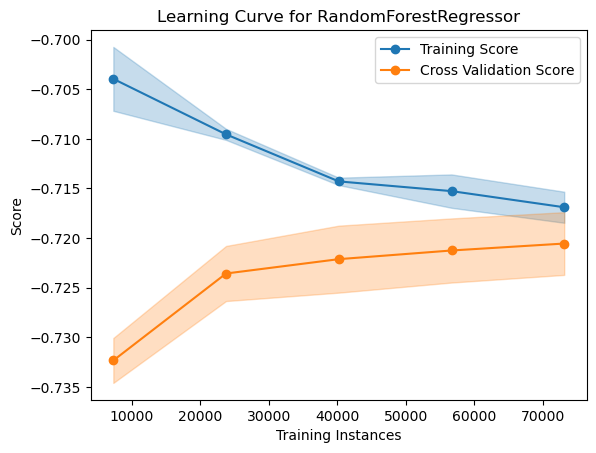

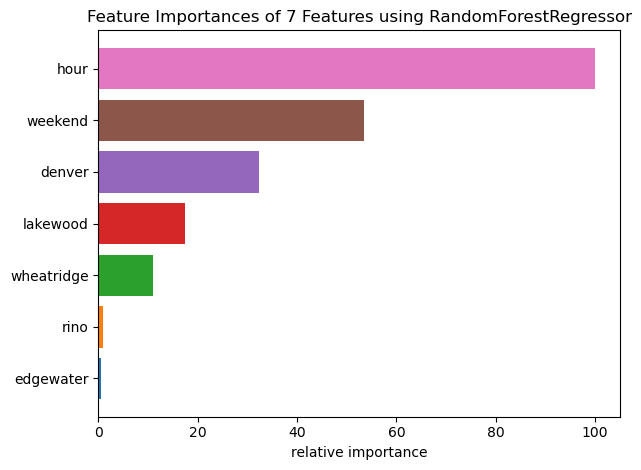

<AxesSubplot:title={'center':'Feature Importances of 7 Features using RandomForestRegressor'}, xlabel='relative importance'>

In [23]:
# residuals_plot = ResidualsPlot(rf)
# residuals_plot.fit(X_train, y_train).score(X_test, y_test)
# residuals_plot.show()

rf.fit(X_train, y_train)

lc = LearningCurve(rf, scoring='neg_root_mean_squared_error', cv=3)
lc.fit(X_train, y_train).score(X_test, y_test)
lc.show()

fi = FeatureImportances(rf)
fi.fit(X_train, y_train).score(X_test, y_test)
fi.show()

Take-Aways:

Further model tuning to optimize the best baseline perform (tree-based random-forest) still doesn't improve RMSE score for our target variable. However, the model does seem to generalize well to the test-set which is to be expected due to the fact that this project involved generating the source datasets. 
RMSE of around 1 indicates that the model is, on average, off by 1 tech in predicting how many a clinic needs at any given moment in time, for any location. Since majority of the instances involve more than 1 available tech at a nearby clinic, this model will only need to be executed occasionally throughout the day for the TecNav navigator app. 
Based on the learning curve, there is no immediate danger of model overfitting as the increased number of train instances is contributing to a better validation RMSE score.

Based on the feature importances, the hour of the day seems to be the most important feature to determine a clinic's need for the number of technicians, more than the actual location information. The type of day also seems to play a huge role. In terms of the location, knowing whether a patient record belongs to the Denver clinic seems to be the most important location to assess while predicting the target---since the EDA showed that this clinic sees the largest traffic, this might indicate the total patient count to be a significant factor in forecasting the number of needed technicians.

Although this was a fairly limited feature-set that limits our ability to be able to conduct a feature-selection investigation, the advantage of constructing a model in this fashion is the translatable application to real-world data from potential clients. As we cannot predict what attributes we can get from a client's dataset and its predictive-power, a simpler model complexity with features that will likely be present was the avenue we chose here. Nevertheless, these attributes may not prove useful with new datasets and therefore, it would be prudent to explore modeling techniques that doesn't rely on specific attributes other than the target variable itself. To that extent, an alternative forecasting approach will be conducted below.

---
---

## 3C: Modeling Part II

**Objective**: Construct, validate, and evaluate time series analyses to predict rolling count based on past patient records.

---

### Feature engineering to prepare data for Time-Series:

In [24]:
filtered_df = past_patients_df[['visit_date', 'visit_location', 'checkin_time', 'needed_num_techs']].copy()
filtered_df['visit_date'] = filtered_df.visit_date.apply(lambda x: str(x))

def floor_dt(current):
    today = date.today()
    current = datetime.combine(today, current)
    rounded_time = current - (current - datetime.min) % timedelta(minutes=15)
    return str(rounded_time.time())[:-3]
filtered_df['interval_time'] = filtered_df.checkin_time.apply(lambda x: floor_dt(x))

filtered_df = filtered_df.groupby(['visit_date', 'visit_location', 'interval_time']).median().round().reset_index(drop=False).sort_values(by=['visit_location', 'visit_date', 'interval_time'])
filtered_df = filtered_df.sort_values(by=['visit_date', 'interval_time', 'visit_location'])
filtered_df

,visit_date,visit_location,interval_time,needed_num_techs
36,2021-05-01,edgewater,08:00,1.0
132,2021-05-01,wheatridge,08:00,1.0
66,2021-05-01,lakewood,08:15,1.0
101,2021-05-01,rino,08:15,1.0
0,2021-05-01,denver,08:30,1.0
...,...,...,...,...
59448,2022-04-30,denver,19:15,1.0
59449,2022-04-30,denver,19:30,1.0
59515,2022-04-30,lakewood,19:30,2.0
59450,2022-04-30,denver,19:45,2.0


In the code block above, each check in time was rounded down to the most recent 15-minute mark, for standardization across the days to be able to construct a model, as was done before the machine-learning model explorations in Part I. In order to use time-series, however, another step is required. Not only do the times have to be standardized, there needs to be an even interval between each time period every day. For example, if a check-in time occured at 10:13 and the next occured at 10:31, a 15-min interval rounding would convert them into 10:00 and 10:30, but there will be a missing record at 10:15. Therefore, these must be included with a forward-fill to ensure there is consistency in the intervals before employing any time series models. These data engineering steps will be conducted below.

In [25]:
filtered_df = filtered_df[filtered_df.visit_date.str.contains('2021-05')]

all_intervals = filtered_df.interval_time.unique()
rows = []
for d in filtered_df.visit_date.unique():
    for i in all_intervals:
        rows.append([d, 'denver', i])
        rows.append([d, 'wheatridge', i])
        rows.append([d, 'edgewater', i])
        rows.append([d, 'rino', i])
        rows.append([d, 'lakewood', i])
ts_df = pd.DataFrame(rows, columns=['visit_date', 'visit_location', 'time'])

ts_df = ts_df.sort_values(by=['visit_date', 'time', 'visit_location'])
ts_df

,visit_date,visit_location,time
0,2021-05-01,denver,08:00
2,2021-05-01,edgewater,08:00
4,2021-05-01,lakewood,08:00
3,2021-05-01,rino,08:00
1,2021-05-01,wheatridge,08:00
...,...,...,...
7435,2021-05-31,denver,19:45
7437,2021-05-31,edgewater,19:45
7439,2021-05-31,lakewood,19:45
7438,2021-05-31,rino,19:45


A new dataframe was generated above will all the possible time intervals for every day in the filtered timeframe of interest. 

In [26]:
ts_df['needed_num_techs'] = ts_df[['visit_location', 'visit_date', 'time']].apply(lambda x: filtered_df[
    (filtered_df.visit_location == x[0]) & (filtered_df.visit_date == x[1]) & (filtered_df.interval_time == x[2])
]['needed_num_techs'].values, axis=1)
ts_df['needed_num_techs'] = ts_df['needed_num_techs'].apply(lambda x: x[0] if len(x)>0 else np.nan)
ts_df = ts_df.fillna(method='ffill')
ts_df = ts_df.fillna(1)
ts_df

,visit_date,visit_location,time,needed_num_techs
0,2021-05-01,denver,08:00,1.0
2,2021-05-01,edgewater,08:00,1.0
4,2021-05-01,lakewood,08:00,1.0
3,2021-05-01,rino,08:00,1.0
1,2021-05-01,wheatridge,08:00,1.0
...,...,...,...,...
7435,2021-05-31,denver,19:45,1.0
7437,2021-05-31,edgewater,19:45,1.0
7439,2021-05-31,lakewood,19:45,1.0
7438,2021-05-31,rino,19:45,2.0


Each missing time-interval slot was filled with its most recent value to complete the feature engineering process and the first slot of each day (if missing) was filled with 1, as every clinic will at least need 1 technician to start the day, no matter the number of patients.

In [27]:
ts_df['dt'] = ts_df[['visit_date', 'time']].apply(lambda x: x[0] + ' ' + x[1], axis=1)

In [28]:
denver_df = ts_df[ts_df.visit_location == 'denver']
wheatridge_df = ts_df[ts_df.visit_location == 'wheatridge']
edgewater_df = ts_df[ts_df.visit_location == 'edgewater']
rino_df = ts_df[ts_df.visit_location == 'rino']
lakewood_df = ts_df[ts_df.visit_location == 'lakewood']

The engineered dataset was broken by location to explore ARIMA methods for each clinic separately.

### ARIMA:

In [29]:
denver_df

,visit_date,visit_location,time,needed_num_techs,dt
0,2021-05-01,denver,08:00,1.0,2021-05-01 08:00
5,2021-05-01,denver,08:15,1.0,2021-05-01 08:15
10,2021-05-01,denver,08:30,1.0,2021-05-01 08:30
15,2021-05-01,denver,08:45,2.0,2021-05-01 08:45
20,2021-05-01,denver,09:00,2.0,2021-05-01 09:00
...,...,...,...,...,...
7415,2021-05-31,denver,18:45,1.0,2021-05-31 18:45
7420,2021-05-31,denver,19:00,1.0,2021-05-31 19:00
7425,2021-05-31,denver,19:15,2.0,2021-05-31 19:15
7430,2021-05-31,denver,19:30,2.0,2021-05-31 19:30


In [30]:
denver_df = denver_df[denver_df.visit_date.isin(['2021-05-03', '2021-05-04',
       '2021-05-05', '2021-05-06', '2021-05-07', '2021-05-08',
       '2021-05-09'])]

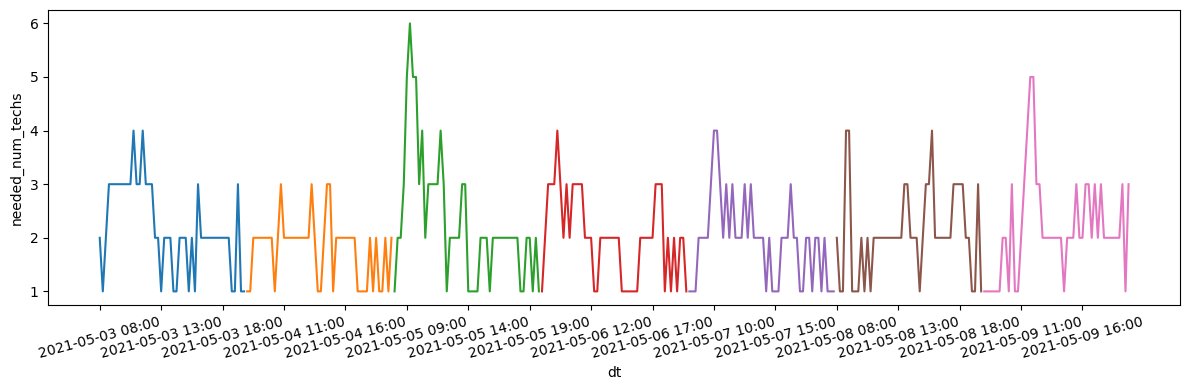

In [31]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(x=denver_df['dt'], y=denver_df['needed_num_techs'], hue=denver_df['visit_date'], legend=False)
plt.xticks(denver_df.dt.tolist()[0::20],  rotation=15)
plt.tight_layout()
plt.show()

#### Test for stationarity:

In [ ]:
denver_df = denver_df.set_index('dt')[['needed_num_techs']]

In [ ]:
#Ho: It is non stationary
#H1: It is stationary

adf_results = adfuller(denver_df)
print('ADF Test Statistic: ', adf_results[0])
print('p-value: ', adf_results[1])
print('# of Lags Used: ', adf_results[2])
print('# of Obs. Used: ', adf_results[3])

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

The NullH of ADF is the data is non stationary. The p-value below the level of significance (0.05) indicates strong evidence against the null hypothesis(Ho) enabling us to reject it and retain the alternate that the data has no unit root and is stationary. Therefore, ARMA/ARIMA models are feasible with this data. Furthermore, the ADF results indiciate no further need to implement any differencing to transform the data into stationary.


In [ ]:
autocorrelation_plot(denver_df.needed_num_techs)
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

plot_acf(denver_df.needed_num_techs, ax=ax[0])
plot_pacf(denver_df.needed_num_techs, ax=ax[1])

plt.tight_layout()
plt.show()

 4,0,2

In [ ]:
# fit model
model = ARIMA(denver_df.needed_num_techs, order=(3,0,4))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [ ]:
# split into train and test sets
X = denver_df.needed_num_techs.values

size = int(len(X) * 0.7)  # 235
train, test = X[0:size], X[size:len(X)]
history = [i for i in X]
predictions = []

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, [round(i) for i in predictions]))
print('Test RMSE: ', round(rmse, 3))


# plot forecasts against actual outcomes
fig, ax = plt.subplots(1,1,figsize=(12, 4))
plt.plot(X[:235], 'c-')
plt.plot([i for i in range(235, len(X))], X[235:], 'c--')
plt.plot([i for i in range(235, len(X))], [round(i) for i in predictions], color='red')

plt.tight_layout()
plt.legend(['Train', 'Test', 'Prediction'])
plt.show()

#### Conduct time-series (ARIMA) study on for an entire month for each location to examine mean RMSE:

In [ ]:
from time import time
t1 = time()
def exec_arima(loc):
    """Conducts ARIMA time-series analysis for input location and outputs RMSE averaged out for all dates."""
    
    # Keep track of daily RMSE values
    rmses = []
    
    # Iterate through each day of past year dataset
    for dat in ts_df.visit_date.unique().astype('str'):
        
        # Filter dataset for specified location and aggragate interval times
        df = ts_df[(ts_df.visit_date == dat) & (ts_df.visit_location == loc)].copy()
        df = df[['time', 'needed_num_techs']]
        df = df.groupby('time').median()
        
        # Fit ARIMA model for the day and track predictions
        X = df.values
        history = [i for i in X]
        preds = []
        for t in range(len(X)):
            ar = ARIMA(history, order=(1,0,1))
            ar_fit = ar.fit()
            pred = ar_fit.forecast()
            preds.append(pred[0])
            history.append(X[t])
        rmse = np.sqrt(mean_squared_error(X, preds))
        rmses.append(rmse)    
    
    return np.mean(rmses)

print("Mean RMSE for Denver via ARIMA: ", exec_arima('denver'))
print("Mean RMSE for Edgewater via ARIMA: ", exec_arima('edgewater'))
print("Mean RMSE for Wheatridge via ARIMA: ", exec_arima('wheatridge'))
print("Mean RMSE for Rino via ARIMA: ", exec_arima('rino'))
print("Mean RMSE for Lakewood via ARIMA: ", exec_arima('lakewood'))
time()-t1

The above study shows similar RMSE scores to the random forest regressor, meaning that the ARIMA model is performing on par (for the month of May 2021). Due to the extra time and model complexity of implementing this time series within the TecNav algorithm, the optimized random forest is the better choice to move forward with at this point.

---
---

## 3E: Technician Navigation

**Objective**: Implement technician navigation strategies based on past patient records.

---

Use past patients for ML part, feed new patients to model.

### Re-calibrate scheduling to a lower number of assigned techs per clinic:

In [ ]:
### APPROACH 1: REDUCE NUMBER OF CLIENT-BASED SCHEDULED TECHNICIANS ("old way") BY SPECIFIED AMOUNT 

# Define variables based on desired specs
reduce_by = 1

# Reduce tech assignments by specified amount
past_patients_df['new_num_techs'] = past_patients_df.assigned_num_techs.apply(lambda x: x-1)
new_patients_df['new_num_techs'] = new_patients_df.assigned_num_techs.apply(lambda x: x-1)
new_patients_df[['visit_location', 'visit_date', 'assigned_num_techs', 'new_num_techs']]

In [ ]:
# ### APPROACH 2: REDUCE NUMBER OF CLIENT-BASED SCHEDULED TECHNICIANS ("old way") BY DESIRED QUANTILE 

# # Define variables based on desired specs
# q = 0.75

# # Retrieve specified quantile rolling count based on each day/location's aggregated data
# schedule_df = df.groupby(['visit_location', 'visit_date', 'visit_day']) \
#     .quantile(q=q).reset_index(drop=False)[['visit_location', 'visit_date', 'rolling_ct']]

# # Compute new tech assignments based on desired quantile of rolling patient count
# schedule_df['new_num_techs'] = schedule_df.rolling_ct.apply(lambda x: int(x/3)+1 if x%3 != 0 else int(x/3))

# # Create dictionary object consisting of assigned number of techs per date&location
# schedule_zipper = zip(schedule_df.visit_date, schedule_df.visit_location, schedule_df.new_num_techs)
# schedule_dict = {}
# for i in schedule_zipper:
#     schedule_dict[(i[0], i[1])] = i[2]

# # Assign techs in patient logs based on created dictionary
# df['new_num_techs'] = df[['visit_date', 'visit_location']] \
#     .apply(lambda x: (x[0], x[1]), axis=1) \
#     .map(schedule_dict)

In [ ]:
cols = new_patients_df.columns.tolist()

### Simulate tech-navigation for past patient records:

Thoughts, Ideas, Areas for Improvement:

- Right now, tech count is being updated instantaenously, rather than realistic 10-15 min interval after (to account for drive time, etc.)

- Implement time-series ML?? If nearest clinic has only 1 available tech to send, then conduct time series to predict if patient count for that clinic will increase or decrease. If increase, then use next location to pull tech from, otherwise, use the current (nearest) location. ML not needed if available count is >1 because that clinic still has extra hands available and it would be a waste of computational power to conduct ML at that point

In [ ]:
!python uc_navigator.py 'new'

#### Analyze results:

In [ ]:
clinic_distances = {
    ('denver', 'rino'): 2, 
    ('wheatridge', 'edgewater'): 2,
    ('rino', 'denver'): 1.9, 
    ('edgewater', 'wheatridge'): 2,
    ('wheatridge', 'lakewood'): 4.8, 
    ('rino', 'wheatridge'): 7.5,
    ('edgewater', 'denver'): 5,  
    ('lakewood', 'wheatridge'): 12,
    ('wheatridge', 'denver'): 6.3,  
    ('edgewater', 'lakewood'): 4.4,
    ('denver', 'lakewood'): 8,  
    ('lakewood', 'edgewater'): 4.3,
    ('wheatridge', 'rino'): 7.8,  
    ('rino', 'lakewood'): 10.7,
    ('denver', 'edgewater'): 5.1,  
    ('lakewood', 'rino'): 11,
    ('rino', 'edgewater'): 7.8,  
    ('edgewater', 'rino'): 7.7,
    ('lakewood', 'denver'): 7.5,   
    ('denver', 'wheatridge'): 6.3
}
print('Number of movements total (May 2022):', len(movements))
distances = pd.DataFrame(pd.Series(movements).value_counts()).reset_index(drop=False).rename(columns={'index': 'routes', 0: 'count'})
distances['dist'] = distances.routes.map(clinic_distances)
distances['cum_route_dist'] = distances[['count', 'dist']].apply(lambda x: x[0] * x[1], axis=1)
total_distance = round(distances.cum_route_dist.sum())
print(total_distance)
display(distances)

In [ ]:
avg_gas_price =  4.04  # avg gas price in Denver
avg_mpg = 24.2  # US Dept of Energy

print('Gas money reimbursements to technicians for navigation moves (for May 2022): ', round(total_distance / avg_mpg * avg_gas_price, 2))

For these 5 clinics in the region, you can schedule 5 technicians less per day and still maintain productivity through TecNav. With an average wage of $21/hr for technicians, this would equate to $91980 saved in compensation over an entire year ($ 7665/month). Note: These savings only account for the wage compensation and not savings on any additional employee benefits. There were 357 amount of moves that occured through TecNav in a single month--this would lead to an estimated $263.94 of gas compensation per month, equating to about $9100 per year. So accounting for this, the urgent care chain would save about $88812.72 for an entire year. This money could be instead invested in further advanced diagnostic tools & imaging equipment that could help the client offer a more comprehensive set of health services or help minimize medical costs for the patients--both of which align with the overall mission of the client's urgent care chain. 

## Run demo:

In [ ]:
# !python uc_navigator.py 'new' -d '2022-05-04'

In [ ]:
!streamlit run TecNav_Demo.py